This notebook expects 3 subfolders in the ./dataset/ directory:
- ds005602-1.0.0/ - can be downloaded using ./dataset/ds005602-1.0.0.sh we got from [OpenNeuro](https://openneuro.org/datasets/ds005602/versions/1.0.0)
    - sub-1/anat/
        - sub-1_FLAIR.nii.gz
        - sub-1_T1w.nii.gz
    - sub-2/anat/...
- freesurfer_orig/ - can be downloaded [here](https://figshare.com/s/f13391a4161b807ce6b0?file=48485917)
    - 1_freesurfer_orig.nii.gz
    - 2_freesurfer_orig.nii.gz
    - ...
- masks/ - optained [here](https://figshare.com/s/31ab43d1829b12ac13e8?file=46130973)
    - 1/
        - 1_MaskInOrig.nii.gz
        - 1_MaskInRawData.nii.gz
    - 2/...

In [1]:
import nibabel
import matplotlib.pyplot as plt

Some utility functions/variables for easier work with dataset:

In [2]:
sets_templates = {
    "ds005602": "dataset/ds005602-1.0.0/sub-{0}/anat/sub-{0}_T1w.nii.gz",
    "flair": "dataset/ds005602-1.0.0/sub-{0}/anat/sub-{0}_FLAIR.nii.gz",
    "masks_orig": "dataset/masks/{0}/{0}_MaskInOrig.nii.gz",
    "masks_raw": "dataset/masks/{0}/{0}_MaskInRawData.nii.gz",
    "orig": "dataset/freesurfer_orig/{0}_freesurfer_orig.nii.gz"
}
def get_image_path(subject_id: int, set_name = "ds005602"):
    return sets_templates[set_name].format(subject_id)

get_image_path(1, "masks_raw")

'dataset/masks/1/1_MaskInRawData.nii.gz'

In [3]:
def load_image(subject_id: int, set_name = "ds005602"):
    return nibabel.load(get_image_path(subject_id, set_name))

def get_slice(image: nibabel.nifti1.Nifti1Image, slice: int):
    return image.get_fdata()[:,:,slice]


# Preview of the data
## A brain MRI scan

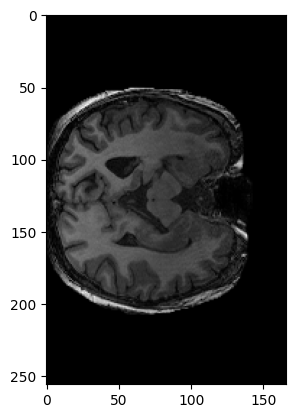

In [4]:
image = load_image(10, "ds005602")
slice = get_slice(image, 128)
plt.imshow(slice, cmap="gray")  

The value limits for the example image

In [5]:
image_data = image.get_fdata()
print("min: ", image_data.min(), "; max: ", image_data.max())

min:  0.0 ; max:  20993.0


## A resection mask

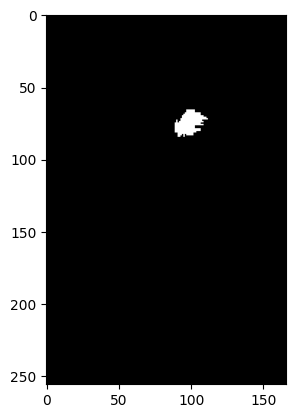

In [6]:
mask = load_image(10, "masks_raw")
slice = get_slice(mask, 128)
plt.imshow(slice, cmap="gray")  

The value limits of the mask

In [7]:
mask_data = mask.get_fdata()
print("min: ", mask_data.min(), "; max: ", mask_data.max())

min:  0.0 ; max:  1.0


# Previewing the scans with their resection masks overlayed

In [8]:
import matplotlib.colors as colors
mask_cmap = colors.LinearSegmentedColormap.from_list("", [(0, 0, 0, 0), (1, 0, 0, 0.4)]) # custom colormap for the mask visualisation - it uses alpha channel to not overlay the brain image where not necessary

In [9]:
def overlay_mask(image, mask):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.imshow(mask, cmap=mask_cmap, alpha=0.5)
    plt.show()

In [10]:
def show_subject_with_mask(subject_id: int, slice: int, set_id: str = "ds005602", mask_set_id: str = "masks_raw"):
    image = get_slice(load_image(subject_id, set_id), slice)
    mask = get_slice(load_image(subject_id, mask_set_id), slice)
    
    overlay_mask(image, mask)

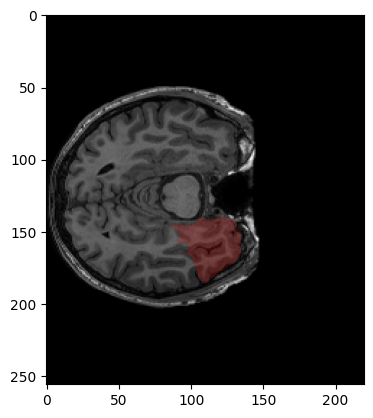

In [11]:
show_subject_with_mask(11, 120, "ds005602", "masks_raw")

# Data analysis
- Are there any missing subjects or masks?
- Do the shapes of the images match with the shapes of the masks?
- What is the distribution of the data shapes?
- What is the distribution of the data?

In [12]:
subject_ids = list(range(1,463))
healthy_ids = list(range(4001, 4100))
all_ids = subject_ids + healthy_ids

In [13]:
id2shapes = {}

In [14]:
def analyze_data(sets):
    if sets not in id2shapes:
        id2shapes[sets] = {}
    mismatched_mask_shapes = []
    missing_masks = []
    missing_subjects = []
    corrupt_subjects = []
    corrupt_masks = []

    shapes_x = {}
    shapes_y = {}
    shapes_z = {}
    for id in all_ids:
        image_shape, mask_shape = id2shapes.get(sets, {}).get(id, (None, None))
        if image_shape is None:
            try:
                image_shape = load_image(id, sets[0]).get_fdata().shape
            except FileNotFoundError:
                missing_subjects.append(id)
                continue
            except nibabel.loadsave.ImageFileError:
                corrupt_subjects.append(id)
        if mask_shape is None and id<4000:
            try:
                mask_shape = load_image(id, sets[1]).get_fdata().shape
            except FileNotFoundError:
                if not id in healthy_ids:
                    missing_masks.append(id)
                continue
            except nibabel.loadsave.ImageFileError:
                corrupt_masks.append(id)
        id2shapes[sets][id] = (image_shape, mask_shape)
        if not image_shape or not mask_shape:
            continue
        if not image_shape == mask_shape and id<4000:
            mismatched_mask_shapes.append(id)
            print(f"{id:04d}: {image_shape}, {mask_shape}")
            continue
        shapes_x[image_shape[0]] = shapes_x.get(image_shape[0], 0) + 1
        shapes_y[image_shape[1]] = shapes_y.get(image_shape[1], 0) + 1
        shapes_z[image_shape[2]] = shapes_z.get(image_shape[2], 0) + 1
    return mismatched_mask_shapes, missing_masks, missing_subjects, shapes_x, shapes_y, shapes_z, corrupt_subjects, corrupt_masks

In [15]:
import numpy as np


def remap_bins(bins, counts, num_bins):
    previous_lim = 0
    bins_arr = np.array(bins)
    bins_min = bins_arr.min()
    bins_max = bins_arr.max()
    if bins_min == bins_max:
        return bins, counts
    new_bin_lims = np.linspace(bins_min, bins_max, num_bins)
    counts_arr = np.array(counts)
    new_counts = []
    for lim in new_bin_lims:
        new_counts.append(counts_arr[(previous_lim < bins_arr) & (bins_arr <= lim)].sum())
        previous_lim = lim
    return new_bin_lims, new_counts
        

def plot_histogram(ax, shapes, num_bins, title):
    bins = sorted(shapes.keys())
    counts = np.array([shapes[b] for b in bins])
    remapped_bins, remapped_counts = remap_bins(bins, counts, num_bins)
    bar_width = remapped_bins[1] - remapped_bins[0] if len(remapped_bins)>1 else .5
    ax.bar(remapped_bins, remapped_counts, width=bar_width)
    ax.set_title(title)

def create_histograms(shapes_x, shapes_y, shapes_z, num_bins):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
    plot_histogram(ax1, shapes_x, num_bins, 'X Shapes')
    plot_histogram(ax2, shapes_y, num_bins, 'Y Shapes')
    plot_histogram(ax3, shapes_z, num_bins, 'Z Shapes')
    plt.tight_layout()
    plt.show()

Missing subjects  (N_ms = 021):  [20, 52, 73, 80, 107, 139, 140, 212, 239, 272, 274, 284, 307, 318, 342, 359, 386, 398, 456, 457, 458]
Missing masks     (N_mm = 009):  [12, 115, 261, 269, 326, 331, 353, 368, 437]
Mismatched shapes (N_bs = 000):  []
Corrupt subjects  (N_ms = 000):  []
Corrupt masks     (N_mm = 000):  []


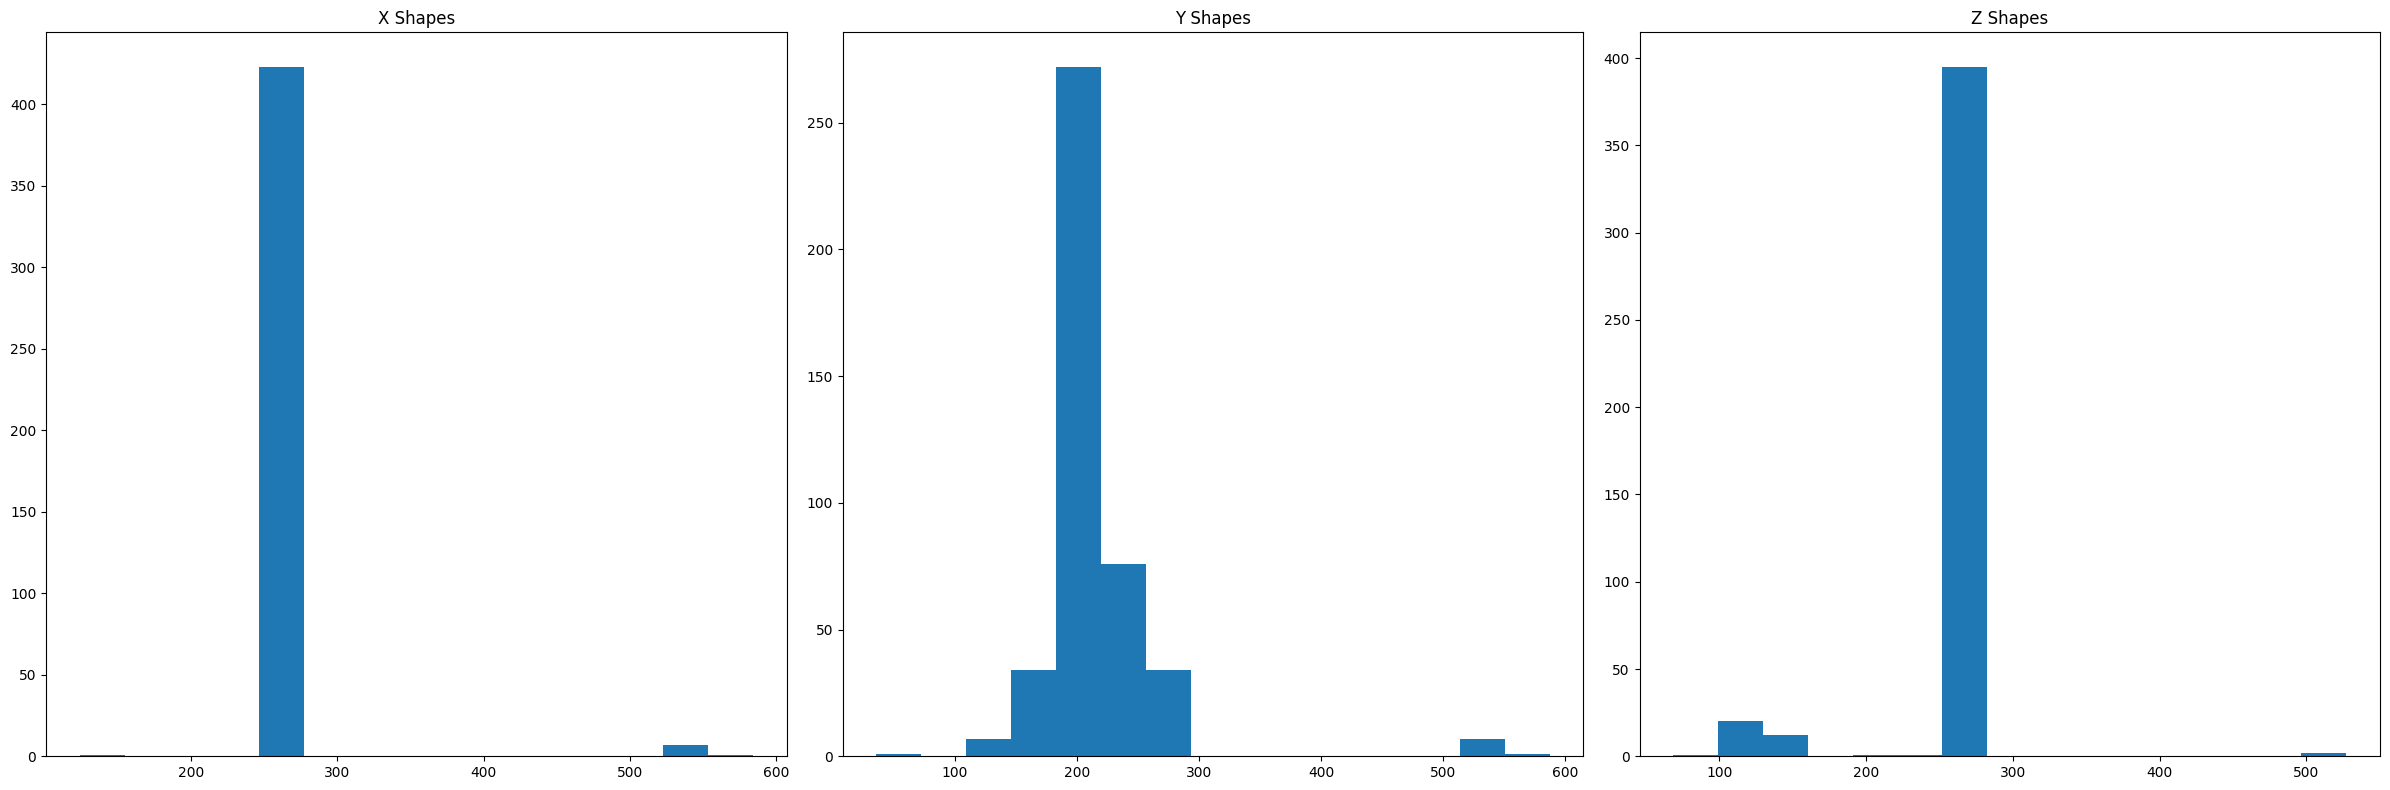

In [16]:
mismatched_mask_shapes, missing_masks, missing_subjects, shapes_x, shapes_y, shapes_z, corrupt_subjects, corrupt_masks = analyze_data(("ds005602", "masks_raw"))
print(f"Missing subjects  (N_ms = {len(missing_subjects):03d}): ", missing_subjects)
print(f"Missing masks     (N_mm = {len(missing_masks):03d}): ", missing_masks)
print(f"Mismatched shapes (N_bs = {len(mismatched_mask_shapes):03d}): ", mismatched_mask_shapes)
print(f"Corrupt subjects  (N_ms = {len(corrupt_subjects):03d}): ", corrupt_subjects)
print(f"Corrupt masks     (N_mm = {len(corrupt_masks):03d}): ", corrupt_masks)
create_histograms(shapes_x, shapes_y, shapes_z, 15)

We found another version of dataset which is already normalized:

0081: (256, 256, 256), (256, 256, 256, 1)
0082: (256, 256, 256), (256, 256, 256, 1)
0194: (256, 256, 256), (256, 256, 256, 1)
0315: (256, 256, 256), (256, 256, 256, 1)
0341: (256, 256, 256), (256, 256, 256, 1)
0400: (256, 256, 256), (256, 256, 256, 1)
Missing subjects  (N_ms = 021):  [20, 52, 73, 80, 107, 139, 140, 212, 239, 272, 274, 284, 307, 318, 342, 359, 386, 398, 456, 457, 458]
Missing masks     (N_mm = 009):  [12, 115, 261, 269, 326, 331, 353, 368, 437]
Mismatched shapes (N_bs = 006):  [81, 82, 194, 315, 341, 400]


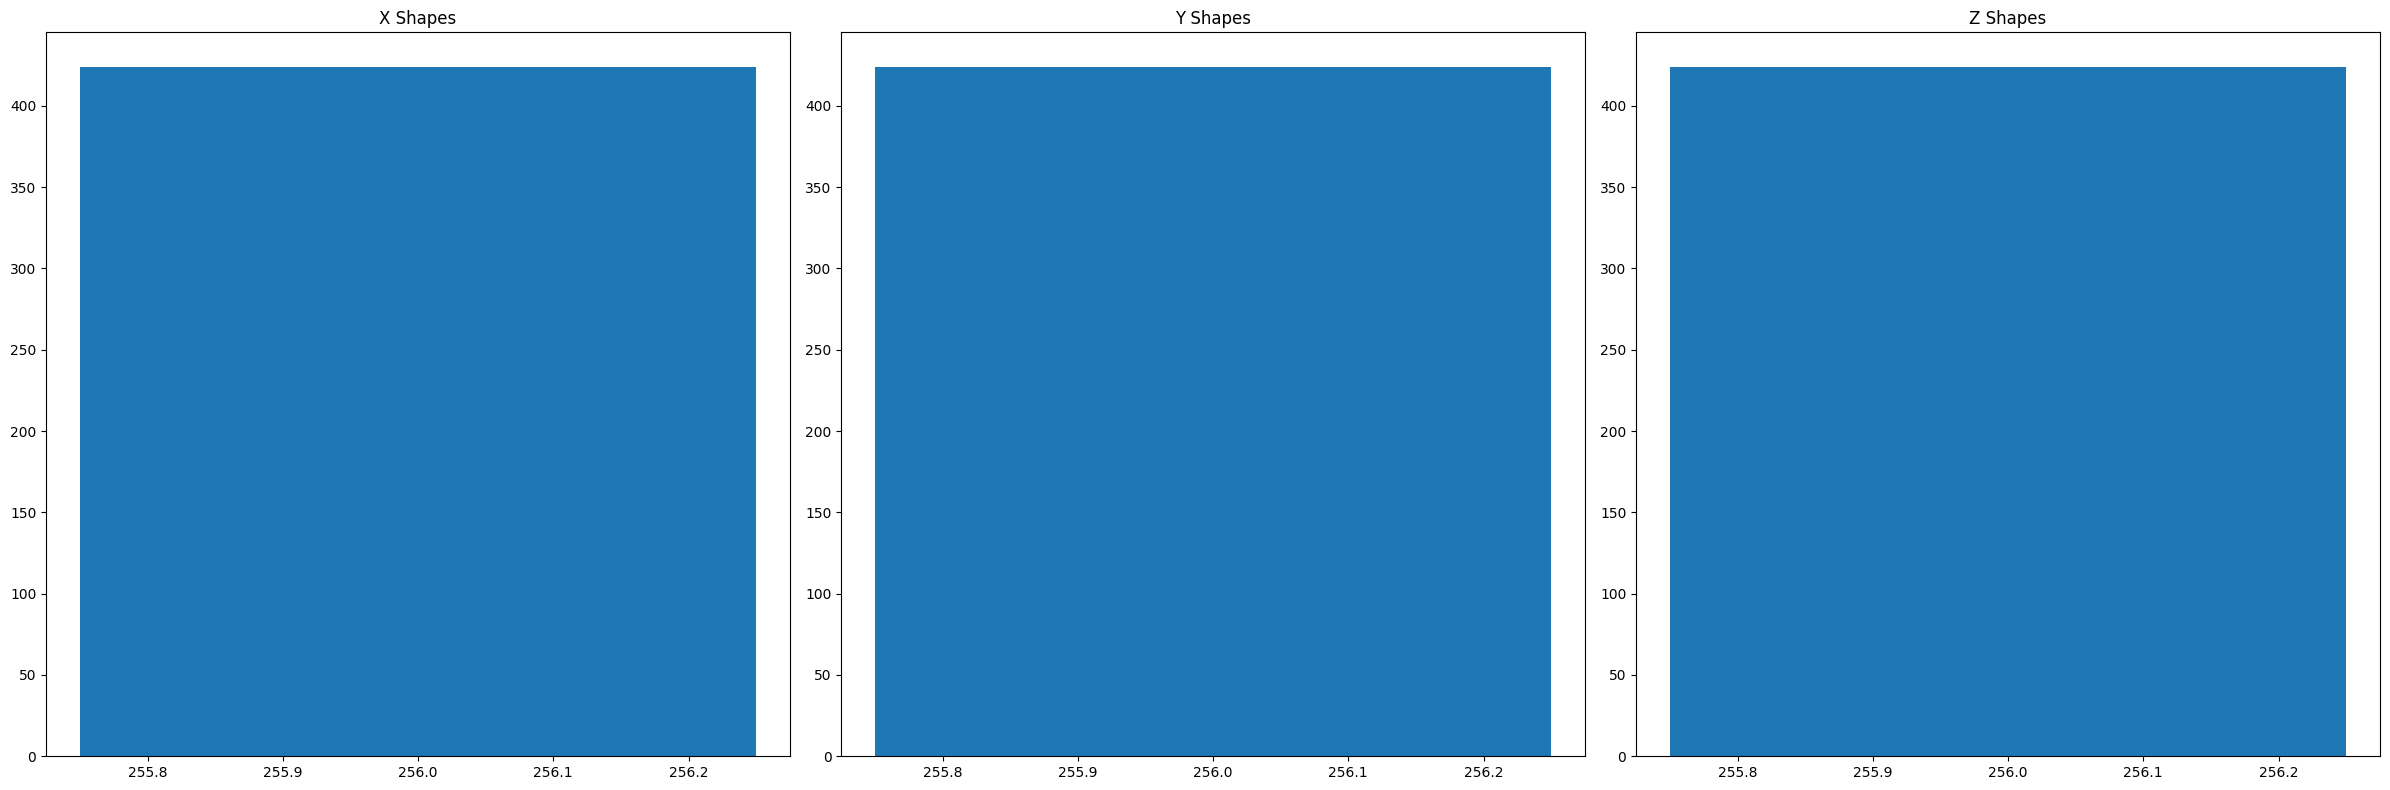

In [17]:
mismatched_mask_shapes, missing_masks, missing_subjects, shapes_x, shapes_y, shapes_z, corrupt_subjects, corrupt_masks = analyze_data(("orig", "masks_orig"))
print(f"Missing subjects  (N_ms = {len(missing_subjects):03d}): ", missing_subjects)
print(f"Missing masks     (N_mm = {len(missing_masks):03d}): ", missing_masks)
print(f"Mismatched shapes (N_bs = {len(mismatched_mask_shapes):03d}): ", mismatched_mask_shapes)
create_histograms(shapes_x, shapes_y, shapes_z, 15)

All images are 256 in all dimensions, except for 6 images listed above that have another 4th dimension, but it's singular. This will have to be handled by the training script.

It has the dimensions in a different order than before - compare this back-to-front view

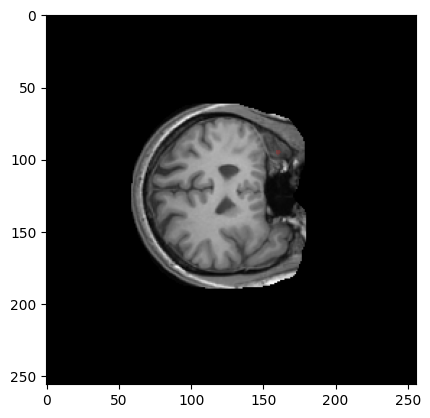

In [18]:
show_subject_with_mask(250, 160, "orig", "masks_orig")

to the previous top-down

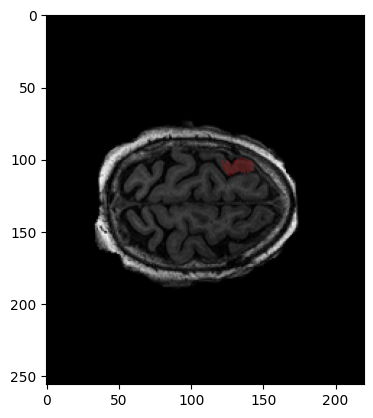

In [19]:
show_subject_with_mask(81, 200, "ds005602", "masks_raw")

## Scans distribution analysis

In [20]:
def update_histogram(hist, data):
    hist += np.histogram(data, bins=256, range=(0, 256))[0]
    return hist

In [21]:
sets = ("orig", "masks_orig")
mri_histogram = np.zeros((256,), dtype=np.int64)
masks_histohram = np.zeros((256,), dtype=np.int64)
for id in all_ids:
    try:
        image_data = load_image(id, sets[0]).get_fdata()
        mri_histogram = update_histogram(mri_histogram, image_data)
    except (FileNotFoundError, nibabel.loadsave.ImageFileError):
        continue
    if id not in healthy_ids:
        try:
            mask_data = load_image(id, sets[1]).get_fdata()
            masks_histohram = update_histogram(masks_histohram, mask_data)
        except (FileNotFoundError, nibabel.loadsave.ImageFileError):
            continue


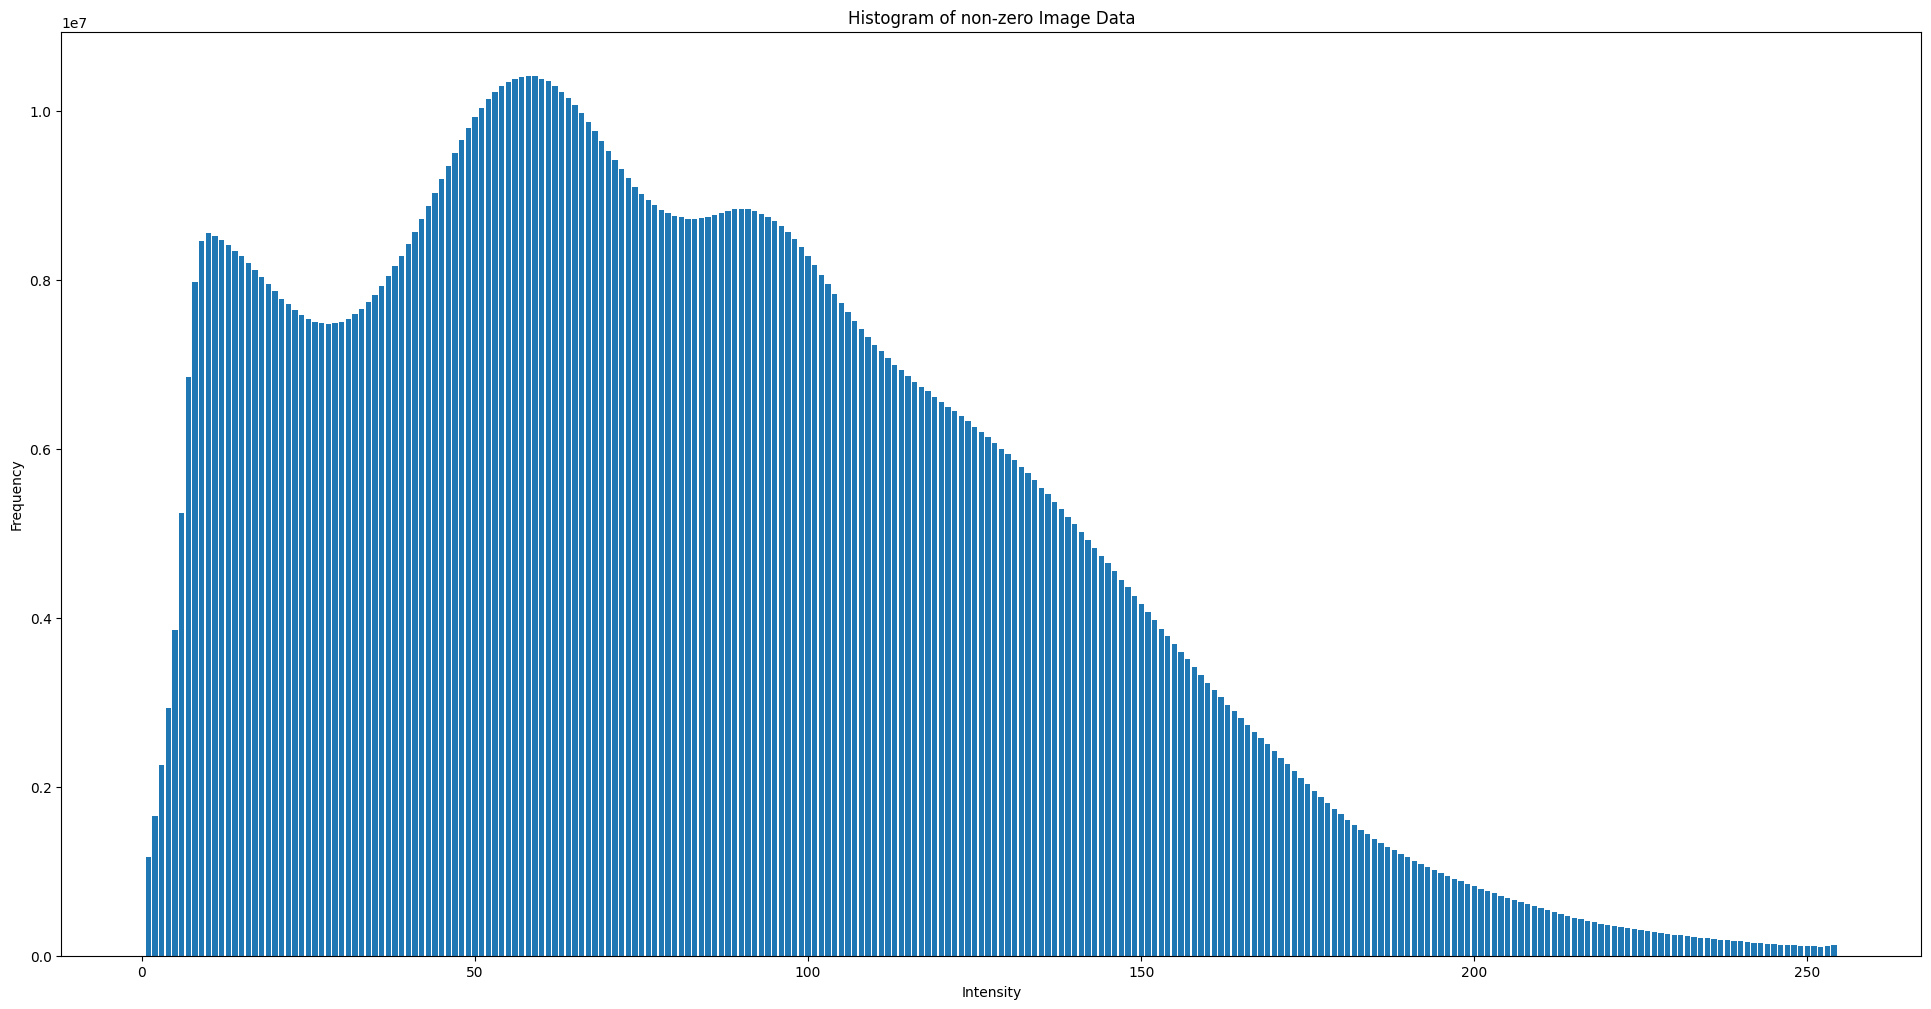

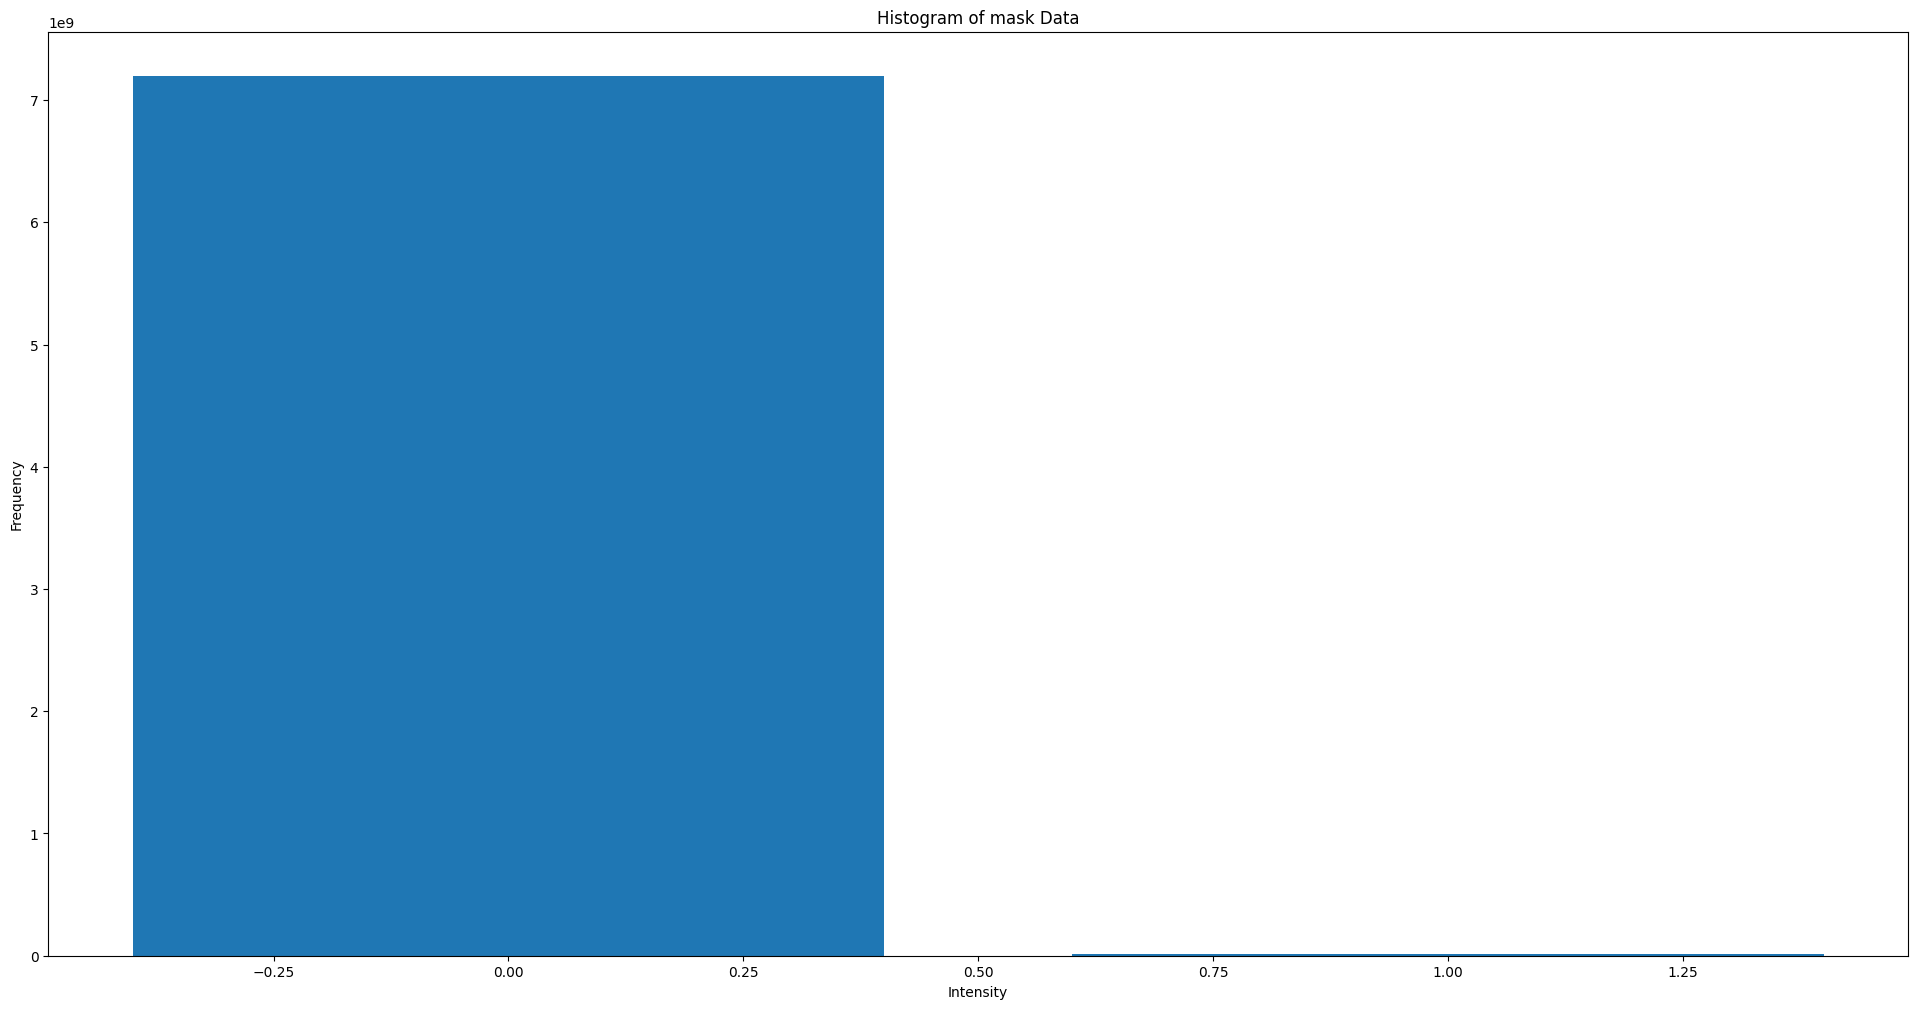

In [22]:
plt.figure(figsize=(24,12))
plt.bar(range(1, 255), mri_histogram[1:255])
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of non-zero Image Data')
plt.show()

plt.figure(figsize=(24,12))
plt.bar(range(0, 2), masks_histohram[0:2])
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of mask Data')
plt.show()

In [23]:
print("Fraction of masked voxels: ", masks_histohram[1]/(masks_histohram[0]+masks_histohram[1]))

Fraction of masked voxels:  0.0020159245923508044


We can't use 2 additional subjects, because we are unable to load their data:

In [24]:
load_image(122, "masks_orig")

ImageFileError: File dataset/masks/122/122_MaskInOrig.nii.gz is not a gzip file

In [25]:
load_image(242, "masks_orig")

ImageFileError: File dataset/masks/242/242_MaskInOrig.nii.gz is not a gzip file